In [240]:
%load_ext autoreload
%autoreload 2

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

from fastai import *
from fastai.vision import *

In [2]:
PATH = Path('../data/whale/')

In [3]:
PATH.ls()

[PosixPath('../data/whale/train'),
 PosixPath('../data/whale/train.csv'),
 PosixPath('../data/whale/sample_submission.csv'),
 PosixPath('../data/whale/test')]

### Check Data

In [7]:
train = (PATH/'train').ls()
test = (PATH/'test').ls()

In [8]:
len(train), len(test)

(25361, 7960)

../data/whale/train/5b0e76d75.jpg


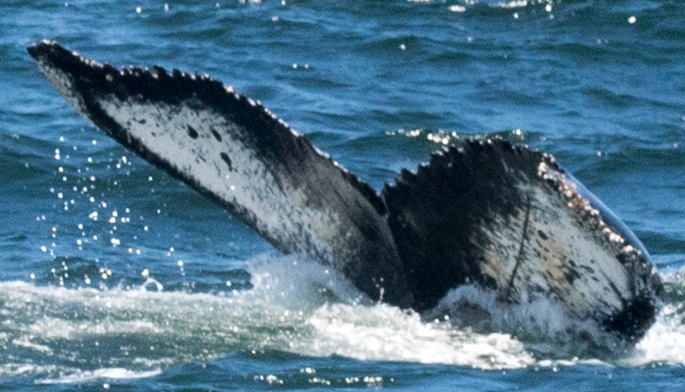

In [13]:
# show random training image
rand_img_path = np.random.choice(train)
print(rand_img_path)
img = open_image(rand_img_path); img

../data/whale/test/5a03ef706.jpg


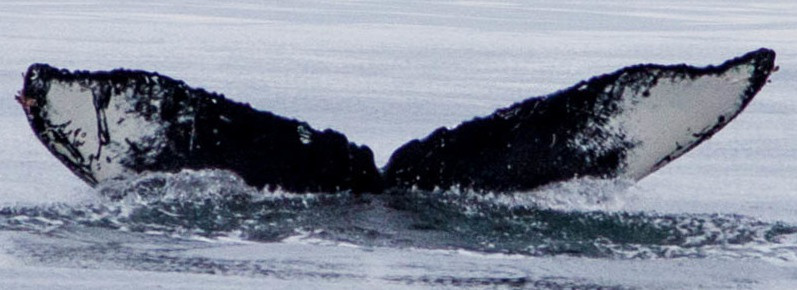

In [14]:
# show random test image
rand_img_path = np.random.choice(test)
print(rand_img_path)
img = open_image(rand_img_path); img

In [15]:
img.size

torch.Size([290, 797])

### DataBunch

Validation:

- if count == 1: to train
- if count == 2: 1 to train 1 to valid

In [336]:
train_df = pd.read_csv(PATH/"train.csv")

In [337]:
train_df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [338]:
cls_lists = train_df.groupby("Id").apply(lambda x: list(x['Image']))

In [339]:
cls_lens = cls_lists.apply(lambda x: len(x))

In [340]:
def valid_len(x):
    if x == 1:
        return 0 # put to train if len == 1
    return max(1, int(x*0.1))

In [341]:
valid_lens = cls_lens.apply(valid_len)

In [342]:
cls_df = pd.DataFrame(cls_lists, columns=['Id'])

In [343]:
cls_df['valid_lens'] = valid_lens

In [344]:
valid_names = np.hstack(cls_df.apply(lambda x: np.random.permutation(x['Id'][:x['valid_lens']]), axis=1).values)

In [346]:
len(valid_names)

4023

In [345]:
train_df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [348]:
valid_df = pd.DataFrame({"Image":valid_names, "is_valid":True})

In [351]:
train_df = pd.merge(train_df, valid_df, on="Image", how="left").fillna(False)

In [352]:
train_df['is_valid'].mean()

0.1586293915855053

In [353]:
valid_ids = train_df[train_df.is_valid == True]['Id'].unique()
train_ids = train_df[train_df.is_valid == False]['Id'].unique()

In [354]:
len(train_ids), len(valid_ids)

(5005, 2932)

In [355]:
missing_ids = [id_ for id_ in valid_ids if id_ not in train_ids]

In [356]:
train_df[train_df['Id'].isin(missing_ids)]

,Image,Id,is_valid


In [357]:
itemlist = ImageItemList.from_df(df=train_df, path=PATH, folder="train")

In [358]:
trn_idxs, val_idxs = np.where(~train_df['is_valid'])[0], np.where(train_df['is_valid'])[0]

In [359]:
labellist = itemlist.split_by_idxs(trn_idxs, val_idxs).label_from_df()

In [360]:
tfms = get_transforms(do_flip=True, max_rotate=15, max_zoom=1.30,
                      max_warp=None, max_lighting=0.2, p_affine=0.3,
                      p_lighting=0.3)

In [361]:
# aspect ratio = 2:3
labellist = labellist.transform(tfms=tfms, size=(224, 336))

In [362]:
test_items = ImageItemList.from_folder(PATH/'test')

In [363]:
data = labellist.add_test(test_items).databunch()

In [364]:
data.c

5005

### Baseline Model

In [365]:
from fastai.callbacks import EarlyStoppingCallback, SaveModelCallback
from fastai.train import BnFreeze

In [366]:
from utils import map5

In [369]:
learn = create_cnn(data, arch=models.resnet34, metrics=[accuracy, map5],
                   callback_fns=[])

In [ ]:
learn.lr_find()

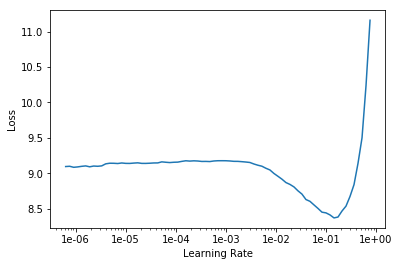

In [246]:
learn.recorder.plot()

In [370]:
learn.fit_one_cycle(10, max_lr=5e-2)

Total time: 22:44
epoch  train_loss  valid_loss  accuracy  map5    
1      5.883075    7.628242    0.238876  0.243483  (02:09)
2      5.978035    7.669016    0.235894  0.239974  (02:07)
3      6.258564    8.383391    0.234402  0.235765  (02:12)
4      5.995908    7.576182    0.240119  0.242046  (02:22)
5      5.904776    7.325680    0.239871  0.241321  (02:21)
6      5.775625    272.585175  0.227442  0.230454  (02:21)
7      5.448447    7.067694    0.238628  0.243210  (02:22)
8      5.224164    35.068489   0.238876  0.245638  (02:21)
9      5.022134    6.722343    0.239622  0.248405  (02:16)
10     4.827087    7.157297    0.240616  0.249801  (02:08)



In [371]:
learn.unfreeze()

In [372]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


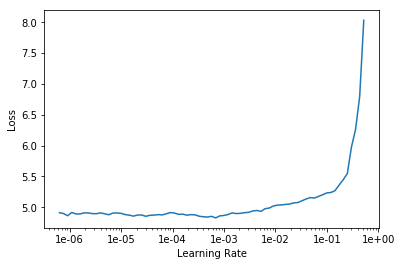

In [373]:
learn.recorder.plot()

In [374]:
learn.fit_one_cycle(10, max_lr=slice(3e-6, 3e-4))

Total time: 23:19
epoch  train_loss  valid_loss  accuracy  map5    
1      4.862044    6.690194    0.240865  0.250253  (02:21)
2      4.840294    6.667046    0.241362  0.250236  (02:22)
3      4.803627    10.887571   0.240119  0.248803  (02:18)
4      4.797209    7.212780    0.240368  0.249577  (02:12)
5      4.801148    6.742537    0.240616  0.250510  (02:22)
6      4.799510    6.627751    0.241362  0.251073  (02:10)
7      4.766323    6.644500    0.242108  0.251839  (02:22)
8      4.731153    6.625403    0.241611  0.252055  (02:23)
9      4.825370    6.621874    0.241859  0.252105  (02:22)
10     4.738705    6.616800    0.242108  0.252258  (02:22)



In [375]:
learn.fit_one_cycle(10, max_lr=slice(3e-6, 3e-4))

Total time: 23:36
epoch  train_loss  valid_loss  accuracy  map5    
1      4.745306    6.650631    0.241859  0.251632  (02:22)
2      4.771303    6.711436    0.242108  0.251421  (02:23)
3      4.759042    6.641757    0.241611  0.251620  (02:22)
4      4.759971    6.692664    0.241611  0.252001  (02:22)
5      4.731416    6.984389    0.242356  0.252138  (02:23)
6      4.691523    6.627769    0.242108  0.252767  (02:22)
7      4.755668    6.774795    0.241859  0.253004  (02:15)
8      4.697865    6.669297    0.242605  0.253401  (02:21)
9      4.714901    7.095275    0.241362  0.252266  (02:22)
10     4.702115    6.873433    0.242356  0.253318  (02:20)



In [376]:
name = "resnet34-baseline"

In [377]:
learn.save(name)

In [5]:
import numpy as np
np.log(1/5005)

-8.518192691749322

### Submission

In [378]:
name = "resnet34-baseline"

In [380]:
learn.load(name);

In [382]:
preds = learn.get_preds(DatasetType.Test)

In [384]:
probas, _ = preds

In [386]:
probas.shape

torch.Size([7960, 5005])